# 地址信息中市级行政单位提取分析

本notebook用于分析专利转让数据中的地址信息，并提取其中的市级行政单位信息。
支持的市级行政单位类型：市、地区、自治州、盟。

In [1]:
import pandas as pd
import re
import numpy as np
from typing import Optional, List

In [2]:
# 读取专利转让数据
# df = pd.read_csv('专利转让sample.csv')
df = pd.read_parquet('专利转让.parquet')
print(f"数据形状: {df.shape}")
print("\n列名:")
print(df.columns.tolist())
print("\n前5行数据:")
df.head()

数据形状: (3193460, 7)

列名:
['当前法律状态', '前权利人', '前地址', '后权利人', '后地址', '申请号', '登记生效日']

前5行数据:


,当前法律状态,前权利人,前地址,后权利人,后地址,申请号,登记生效日
0,专利申请权、专利权的转移,益阳胜希机械设备制造有限公司,413000湖南省益阳市高新区邓石桥镇清溪村,湖南智胜顶科技有限公司,410000湖南省益阳市高新区谢林港镇石桥村,CN201811085889.2,20240423
2,专利申请权、专利权的转移,兰州科时西西里健康科技有限公司,730000甘肃省兰州市兰州新区昆仑山大道3949号科天水性科技产业园,利洁时健康有限公司,英国斯劳,CN201830453730.6,20220621
11,专利申请权、专利权的转移,咸宁仓禾日用品有限公司,437000湖北省咸宁市长江产业园(龟山路19号)3幢,湖北五湖生物科技有限公司,437000湖北省咸宁市咸宁经济开发区长江产业园,CN202220780175.9,20230628
17,专利申请权、专利权的转移,深圳空铁科技股份有限公司,518000广东省深圳市前海深港合作区前湾一路1号A栋201室(入驻深圳市前海商务秘书有限公司),江苏贤君科技有限公司,210000江苏省南京市玄武区玄武大道699-1号3层B301-1,CN201910907150.3,20240914
19,专利申请权、专利权的转移,王毓杨,325000浙江省温州市鹿城区府东路东宝小区4幢105室,徐州致诚会计服务有限公司,221000江苏省徐州市云龙区世茂广场商业内街2及办公1幢1单元910号,CN201811262695.5,20201218


## 市级行政单位提取函数

In [3]:
def extract_city_from_address(address: str) -> Optional[str]:
    """
    从地址字符串中提取城市名称
    
    Args:
        address: 地址字符串
        
    Returns:
        城市名称，如果未找到则返回None
    """
    if pd.isna(address) or address == '':
        return None
    
    # 方法1: 使用正则表达式匹配 "省份+城市市" 模式
    # 匹配格式：XX省XX市 或 XX市（直辖市）
    pattern1 = r'(?:.*?省)?(.*?市)'
    match1 = re.search(pattern1, address)
    
    if match1:
        city = match1.group(1)
        # 过滤掉可能的噪音（如果城市名太短或太长）
        if 2 <= len(city) <= 6:
            return city
    
    # 方法2: 处理特殊情况，如自治区
    pattern2 = r'(?:.*?自治区)?(.*?市)'
    match2 = re.search(pattern2, address)
    
    if match2:
        city = match2.group(1)
        if 2 <= len(city) <= 6:
            return city
    
    return None

In [4]:
def extract_city_advanced(address: str) -> Optional[str]:
    """
    改进版城市提取函数，处理更多边界情况
    支持市级行政单位：市、地区、自治州、盟
    
    Args:
        address: 地址字符串
        
    Returns:
        城市级行政单位名称，如果未找到则返回None
    """
    if pd.isna(address) or address == '':
        return None
    
    # 先去除邮政编码（通常是开头的6位数字）
    address_clean = re.sub(r'^\d{6}', '', address)
    
    # 直辖市处理
    direct_cities = ['北京市', '上海市', '天津市', '重庆市']
    for city in direct_cities:
        if city in address_clean:
            return city
    
    # 市级行政单位提取模式
    # 按优先级顺序：先匹配具体的行政单位类型
    patterns = [
        # 省份 + 市级行政单位
        r'(?:.*?省)(.*?市)',         # XX省XX市
        r'(?:.*?省)(.*?地区)',       # XX省XX地区  
        r'(?:.*?省)(.*?自治州)',     # XX省XX自治州
        # 自治区 + 市级行政单位
        r'(?:.*?自治区)(.*?市)',     # XX自治区XX市
        r'(?:.*?自治区)(.*?地区)',   # XX自治区XX地区
        r'(?:.*?自治区)(.*?自治州)', # XX自治区XX自治州
        r'(?:.*?自治区)(.*?盟)',     # XX自治区XX盟（主要在内蒙古）
        # 开头直接是市级行政单位
        r'^(.*?市)',                 # 开头就是城市名
        r'^(.*?地区)',               # 开头就是地区名
        r'^(.*?自治州)',             # 开头就是自治州名
        r'^(.*?盟)',                 # 开头就是盟名
    ]
    
    for pattern in patterns:
        match = re.search(pattern, address_clean)
        if match:
            city = match.group(1)
            # 验证行政单位名称合理性
            # 检查长度和包含的关键词
            if (2 <= len(city) <= 12 and 
                (city.endswith('市') or city.endswith('地区') or 
                 city.endswith('自治州') or city.endswith('盟'))):
                return city
    
    return None

## 批量提取市级行政单位信息

In [5]:
# 对所有地址进行市级行政单位提取
from tqdm import tqdm
tqdm.pandas(desc="提取前权利人市级单位")
df['前权利人市级单位'] = df['前地址'].progress_apply(extract_city_advanced)

tqdm.pandas(desc="提取后权利人市级单位")
df['后权利人市级单位'] = df['后地址'].progress_apply(extract_city_advanced)

# 查看提取结果
print("市级行政单位提取完成统计:")
print(f"前权利人市级单位提取成功率: {df['前权利人市级单位'].notna().sum()} / {len(df)} ({df['前权利人市级单位'].notna().mean()*100:.1f}%)")
print(f"后权利人市级单位提取成功率: {df['后权利人市级单位'].notna().sum()} / {len(df)} ({df['后权利人市级单位'].notna().mean()*100:.1f}%)")

# 显示提取结果样例
print("\n提取结果样例:")
display_cols = ['前地址', '前权利人市级单位', '后地址', '后权利人市级单位']
df[display_cols].head(10)

提取后权利人市级单位: 100%|██████████| 3193460/3193460 [00:09<00:00, 341879.26it/s]


市级行政单位提取完成统计:
前权利人市级单位提取成功率: 2944717 / 3193460 (92.2%)
后权利人市级单位提取成功率: 2923603 / 3193460 (91.5%)

提取结果样例:


,前地址,前权利人市级单位,后地址,后权利人市级单位
0,413000湖南省益阳市高新区邓石桥镇清溪村,益阳市,410000湖南省益阳市高新区谢林港镇石桥村,益阳市
2,730000甘肃省兰州市兰州新区昆仑山大道3949号科天水性科技产业园,兰州市,英国斯劳,None
11,437000湖北省咸宁市长江产业园(龟山路19号)3幢,咸宁市,437000湖北省咸宁市咸宁经济开发区长江产业园,咸宁市
17,518000广东省深圳市前海深港合作区前湾一路1号A栋201室(入驻深圳市前海商务秘书有限公司),深圳市,210000江苏省南京市玄武区玄武大道699-1号3层B301-1,南京市
19,325000浙江省温州市鹿城区府东路东宝小区4幢105室,温州市,221000江苏省徐州市云龙区世茂广场商业内街2及办公1幢1单元910号,徐州市
20,734000甘肃省张掖市民乐县南古镇杨武村四组,张掖市,425200湖南省永州市双牌县泷泊镇泷泊竹木科技产业园,永州市
21,214112江苏省无锡市新洲路210号,无锡市,264006山东省烟台市经济技术开发区五指山路11号,烟台市
25,017320内蒙古自治区鄂尔多斯市乌审旗乌审召镇化工项目区,鄂尔多斯市,017318内蒙古自治区鄂尔多斯市乌审旗图克工业园区,鄂尔多斯市
26,214500江苏省泰州市靖江市双鱼路9号,泰州市,214500江苏省泰州市靖江市苏源热电路99号,泰州市
29,545000广西壮族自治区柳州市柳北区三中路118号,柳州市,221200江苏省徐州市睢宁县高作镇刘大庄9号,徐州市


## 市级行政单位分布分析

In [6]:
# 前权利人市级行政单位分布
print("前权利人市级行政单位分布 (Top 10):")
前单位分布 = df['前权利人市级单位'].value_counts().head(10)
print(前单位分布)

print("\n后权利人市级行政单位分布 (Top 10):")
后单位分布 = df['后权利人市级单位'].value_counts().head(10)
print(后单位分布)

# 分析行政单位类型分布
print("\n行政单位类型分布:")
前单位类型 = df['前权利人市级单位'].dropna().apply(lambda x: 
    '市' if x.endswith('市') else
    '地区' if x.endswith('地区') else  
    '自治州' if x.endswith('自治州') else
    '盟' if x.endswith('盟') else '其他'
).value_counts()
print("前权利人单位类型:")
print(前单位类型)

后单位类型 = df['后权利人市级单位'].dropna().apply(lambda x:
    '市' if x.endswith('市') else
    '地区' if x.endswith('地区') else
    '自治州' if x.endswith('自治州') else  
    '盟' if x.endswith('盟') else '其他'
).value_counts()
print("\n后权利人单位类型:")
print(后单位类型)

前权利人市级行政单位分布 (Top 10):
前权利人市级单位
北京市    219684
深圳市    192965
上海市    137480
广州市    132216
苏州市    111054
杭州市     90548
南京市     67865
成都市     63470
天津市     56671
重庆市     56465
Name: count, dtype: int64

后权利人市级行政单位分布 (Top 10):
后权利人市级单位
北京市    220226
深圳市    178656
上海市    147688
广州市    107936
苏州市     93231
杭州市     79676
南京市     63255
重庆市     60398
佛山市     58770
东莞市     55773
Name: count, dtype: int64

行政单位类型分布:
前权利人单位类型:
前权利人市级单位
市      2934944
自治州       8212
地区         988
盟          573
Name: count, dtype: int64

后权利人单位类型:
后权利人市级单位
市      2903810
自治州      15099
地区        3747
盟          947
Name: count, dtype: int64


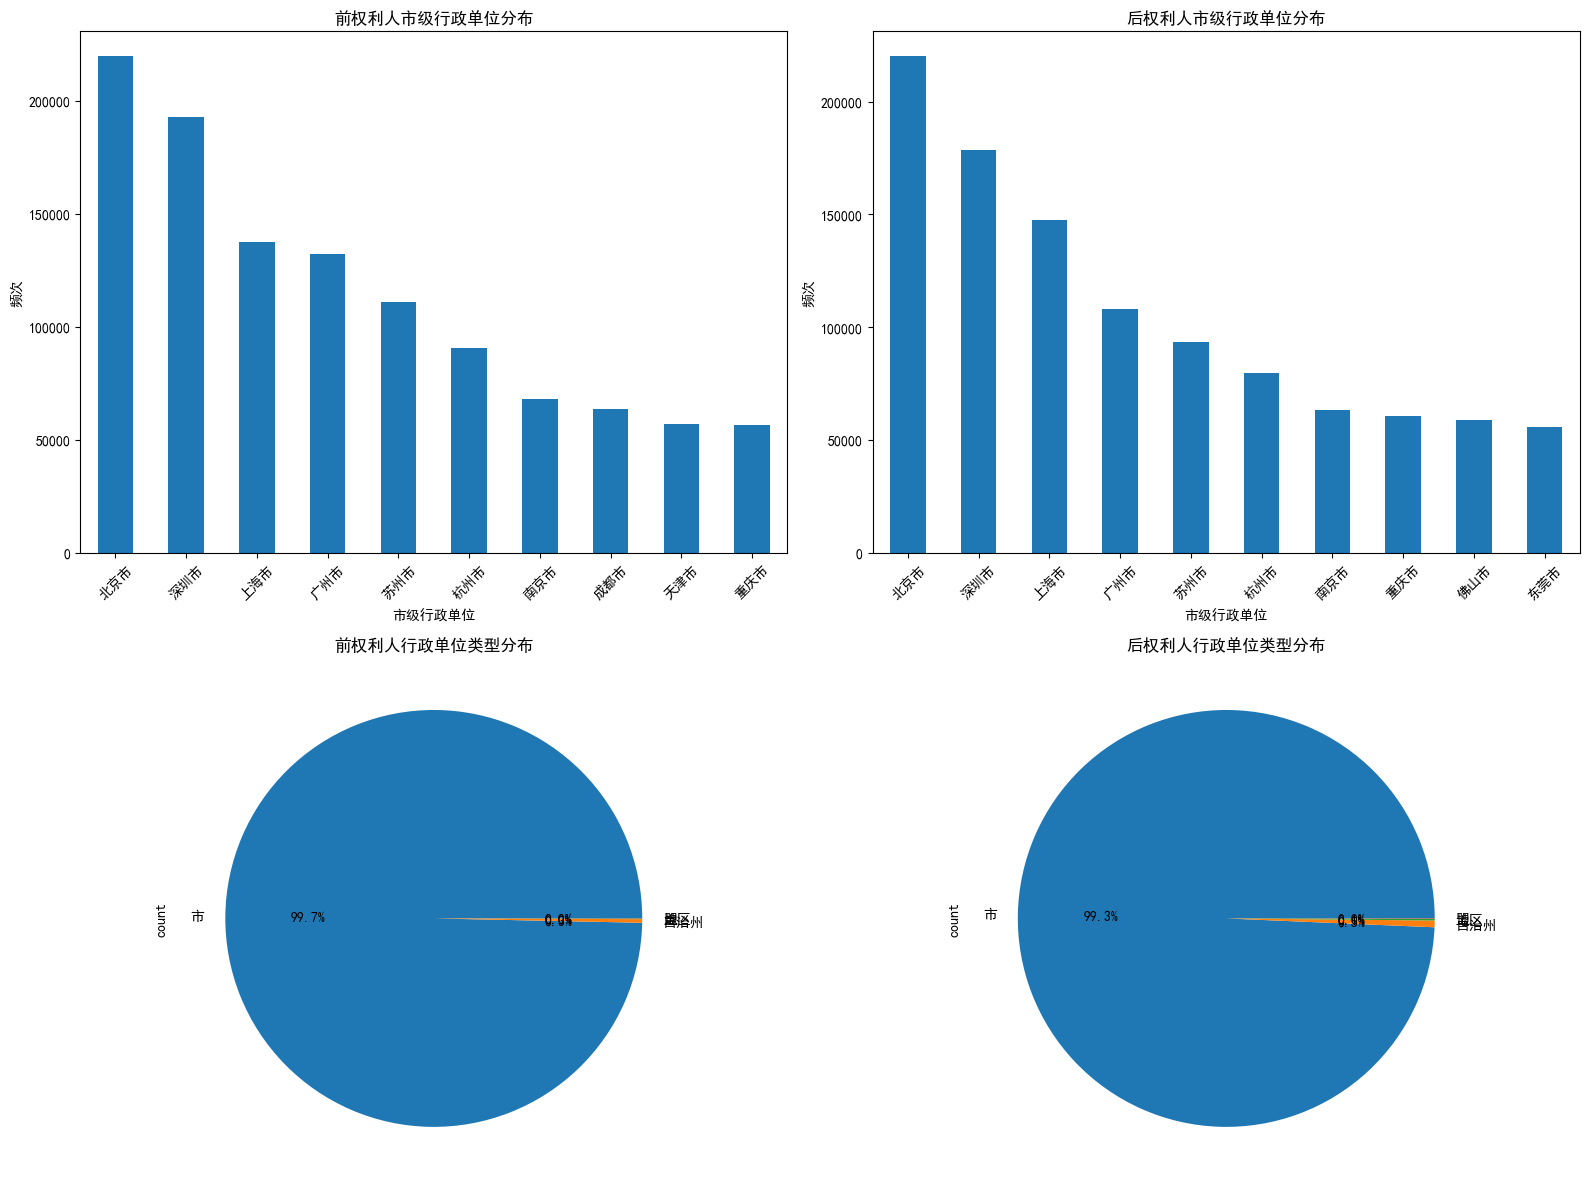

In [7]:
# 市级行政单位转移分析
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False

# 创建市级行政单位转移矩阵（仅显示前10个单位）
top_units = list(set(前单位分布.index.tolist() + 后单位分布.index.tolist()))

# 可视化市级行政单位分布
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 前权利人市级行政单位分布
前单位分布.plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('前权利人市级行政单位分布')
axes[0,0].set_xlabel('市级行政单位')
axes[0,0].set_ylabel('频次')
axes[0,0].tick_params(axis='x', rotation=45)

# 后权利人市级行政单位分布
后单位分布.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('后权利人市级行政单位分布')
axes[0,1].set_xlabel('市级行政单位')
axes[0,1].set_ylabel('频次')
axes[0,1].tick_params(axis='x', rotation=45)

# 前权利人单位类型分布
前单位类型.plot(kind='pie', ax=axes[1,0], autopct='%1.1f%%')
axes[1,0].set_title('前权利人行政单位类型分布')

# 后权利人单位类型分布
后单位类型.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%')
axes[1,1].set_title('后权利人行政单位类型分布')

plt.tight_layout()
plt.show()

## 提取失败的地址分析

In [8]:
# 查看提取失败的地址
failed_前 = df[df['前权利人市级单位'].isna()]['前地址'].dropna()
failed_后 = df[df['后权利人市级单位'].isna()]['后地址'].dropna()

print(f"前权利人市级单位提取失败的地址 ({len(failed_前)} 条):")
for i, addr in enumerate(failed_前.head(10)):
    print(f"{i+1}. {addr}")

print(f"\n后权利人市级单位提取失败的地址 ({len(failed_后)} 条):")
for i, addr in enumerate(failed_后.head(10)):
    print(f"{i+1}. {addr}")

# 分析失败原因
if len(failed_前) > 0 or len(failed_后) > 0:
    print("\n提取失败原因分析:")
    all_failed = list(failed_前) + list(failed_后)
    for addr in all_failed[:5]:  # 只分析前5个失败案例
        print(f"地址: {addr}")
        if not any(suffix in addr for suffix in ['市', '地区', '自治州', '盟']):
            print("  -> 可能原因: 地址中不包含市级行政单位关键词")
        elif addr.strip() == '':
            print("  -> 可能原因: 空地址")
        else:
            print("  -> 可能原因: 格式特殊或国外地址")

前权利人市级单位提取失败的地址 (248722 条):
1. 510000广东省广州高新技术产业开发区科学大道231、233号裙楼B1B2栋一层、二层、三层、四层
2. 日本福冈县申请人:国立大学法人信州大学
3. 韩国首尔
4. 美国加利福尼亚州
5. 中国香港九龙湾宏光道
6. 芬兰埃斯波
7. 日本东京都
8. 日本神奈川县
9. 新加坡启汇城大道一号索拉斯大厦三楼之一
10. 美国马萨诸塞州

后权利人市级单位提取失败的地址 (250918 条):
1. 英国斯劳
2. 日本福冈县申请人:国立大学法人信州大学
3. 韩国首尔
4. 美国加利福尼亚州
5. 芬兰坦佩雷
6. 日本东京都
7. 湖南省长沙经济技术开发区星沙产业基地(长龙街道)凉塘东路1259号
8. 日本神奈川县
9. 加拿大渥太华
10. 美国华盛顿州

提取失败原因分析:
地址: 510000广东省广州高新技术产业开发区科学大道231、233号裙楼B1B2栋一层、二层、三层、四层
  -> 可能原因: 地址中不包含市级行政单位关键词
地址: 日本福冈县申请人:国立大学法人信州大学
  -> 可能原因: 地址中不包含市级行政单位关键词
地址: 韩国首尔
  -> 可能原因: 地址中不包含市级行政单位关键词
地址: 美国加利福尼亚州
  -> 可能原因: 地址中不包含市级行政单位关键词
地址: 中国香港九龙湾宏光道
  -> 可能原因: 地址中不包含市级行政单位关键词


## 保存结果

In [10]:
output_file = '专利转让_带市级行政单位信息.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"结果已保存到: {output_file}")

结果已保存到: 专利转让_带市级行政单位信息.csv


In [ ]:
# 保存带有市级行政单位信息的数据
output_file = '专利转让_带市级行政单位信息.csv'
df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f"结果已保存到: {output_file}")

# 保存市级行政单位提取统计
unit_stats = pd.DataFrame({
    '前权利人市级单位': 前单位分布,
    '后权利人市级单位': 后单位分布
}).fillna(0)

unit_stats.to_csv('市级行政单位分布统计.csv', encoding='utf-8-sig')
print("市级行政单位分布统计已保存到: 市级行政单位分布统计.csv")

# 保存行政单位类型统计
type_stats = pd.DataFrame({
    '前权利人单位类型': 前单位类型,
    '后权利人单位类型': 后单位类型  
}).fillna(0)

type_stats.to_csv('行政单位类型统计.csv', encoding='utf-8-sig')
print("行政单位类型统计已保存到: 行政单位类型统计.csv")